# Baseline Model Development

In [1]:
%load_ext lab_black

In [2]:
import json
import os
from datetime import datetime
from typing import Dict, List, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as skm
from contexttimer import Timer
from scipy.stats import beta
from sklearn.model_selection import ParameterGrid

## About

### Objective
This notebook trains a baseline model for predicting visitors' [propensity to make a purchase on a future visit](https://blog.hubspot.com/agency/predictive-analytics-buyhttps://blog.hubspot.com/agency/predictive-analytics-buy) to the merchandise store on the Google Marketplace, using binary classification.

In ML terms, propensity is the likelihood to buy on a return visit and [this comes from the prediction probability](https://www.analyticsvidhya.com/blog/2021/06/streamlit-for-ml-web-applications-customers-propensity-to-purchase/https://www.analyticsvidhya.com/blog/2021/06/streamlit-for-ml-web-applications-customers-propensity-to-purchase/), which is the [probability that a predicted outcome belongs to one of the two known binary classes](https://discuss.analyticsvidhya.com/t/what-is-the-difference-between-predict-and-predict-proba/67376/4https://discuss.analyticsvidhya.com/t/what-is-the-difference-between-predict-and-predict-proba/67376/4) (in the current case, the known classes are will or will not purchase on future visit).

### Data
Currently, three data splits with transformed data were created by the previous notebook (`03_transform.ipynb`)
1. train
2. validation
3. test

Predictive models will be developed using the training data split and validated against the validation data split. This will be used to optimize hyperparameters.

Based on validation scores, the best
1. model
2. features

will then be
1. trained using the combined training and validation split
2. evaluated using the test split

This workflow is used for
1. Baseline
   - features are not used
2. Machine Learning
   - features will be used (next notebook)

model development.

### Baseline Model Requirements
In this project, ML is used to predict visitor propensity (probability) so the chosenk baseline distribution must produce a [right-skewed](https://www.statology.org/left-skewed-vs-right-skewed/) distribution (histogram) of probabilities. This would indicate that most visitors are predicted to have close to a zero percent probability of making a purchase on a return visit, which is what we saw during EDA in previous notebooks.

With this in mind, we have the following two requirements of a suitable baseline model for predicting visitors' propensity to make a purchase on a future visit
1. If we use a [binary classification discrimination threshold](https://datascience.stackexchange.com/a/5026/17543) of 0.5, then a right-skewed histogram of probabilities will result in most visitors having a probablity of less than the threshold (0.5) meaning they would be classified as *not likely to make a purchase on a return visit to the merchandise store*. This would lead to a predicted class imbalance, which is what we want since we observed this class imbalance in the training data. However, just having a class imbalance is not enough. We need a strong class imbalance since approximately 5% of visitors were observed to make a purchase on a return visit. So, we need to modify the the skew (shape) of the baseline distribution that is chosen to match this expected class imbalance seen in the training data.
2. Since we require probabilities, we need to choose a distribution that can be produce floating point values in the range of 0.0 to 1.0.

### Baseline Model Choices
A normal distribution histogram would have a peak in the center, which would indicate that most visitors have between a 25% and 75% chance of making a return purchase, with the peak at 50%. This would not give a strongly right-skewed histogram. In turn, this would not give a strong class imbalance. So, a normal distribution is not a suitable distribution for baseline predictions of visitors' propensity to make a return purchase.

By comparison, a `beta` distribution's hyperparameters (`a` and `b`) can be chosen to skew the histogram so that most customers have a low probability (propensity) to make a return purchase. This is more realistic for the current use-case and we would want to choose its hyperparameters to give a class balance of close to 95%-5%.

For these reasons, an appropriately shaped `beta` (skewed) distribution is a suitable baseline model for the current use-case.

In order to do this, we will generate randomly sampled predicted probablities (propensity scores) from the `beta` distribution ([1](https://byjus.com/maths/probability-distribution/), [2](https://en.wikipedia.org/wiki/Probability_distribution)) that is [strongly right skewed (positive skew)](https://www.cambridgemaths.org/blogs/skewed-usage-skewed-distribution/) using the `scipy` Python library under the `scipy.stats` module - see the [*beta distribution*](https://byjus.com/maths/beta-distribution/) documentation for the `scipy` package.

### Overall Approach
During baseline model development/validation, the `a` and `b` hyperparameters of the `beta` distribution (baselline model) will be optimized using the validation data. Since this is a baseline model, model training is not required so ML features are not used. Instead, the predicted probabilities (propensities) will be randomly sampled from the `beta` distribution. As a result, the training data split will not be necessary in this notebook. The hyperparameter optimization is required so that the shape of the distribution is chosen to match the class imbalance seen in the validation data.

During baseline model evaluation, the `beta` distribution (baseline model) with the best hyperparameters will be used to make predictions of visitors' probabilities (propensities) of a future purchase in the test data.

### Evaluation Metrics
Due to the class imbalance, evaluation metrics can be difficult to interpret. The precision will generally be very low since there are so few minority class observations in the training data (we assume this is similar to the distribution in the validation and test splits).

Based on this constraint about class imbalance, we will choose the following metrics
1. Area under the precision recall curve
   - this is ideal for imbalanced data, where the priority is on maximizing the precision and recall of the minority class
2. Uplift
   - the first implementation is calculated as follows
     - sort visitors in validation or test data split by predicted probability score
       - the predicted probability score comes from the baseline model (randomly sampled values between 0 and 1 from the `beta` distribution) or ML model
     - divide visitors into 20 percentiles (or ventiles) based on the sorted probability score
     - calculate uplift as the ratio of the average minority class probability in the top 5% (best performing ventile) to the average minority class probability across all ventiles
     - the interpretation of `uplift` is the factor by which the baseline or ML model is more effective than a random model
       - here, a baseline model draws from a `beta` distribution, which will be appropriately shaped during hyperparameter optimization to have a histogram of probabilities that captures the class balance seen during EDA
       - a random model would draw from a normal distribution, which does not have a histogram of prediction probabilities that is correctly shaped to reflect visitor buying patterns (class balance) that we saw during EDA
       - see the above discussion about the required shape of the histogram of sampled probabilities (propensities)
   - the second implementation, called the `lift_score`, is the ratio of correctly predicted observations in the minority class to actual number of minority obsrevations and is calculated using a conusion matrix (with hard labels)
     - see the `mlxtend` library for the [definition of `lift_score`](http://rasbt.github.io/mlxtend/user_guide/evaluate/lift_score/)

### Assumptions
1. The class distribution (or class balance) seen in the training data (explored during EDA) is similar to the distribution in the validation and test data splits.

### Limitations
1. The first definition of `uplift` does not make a comparison of the predicted and true class labels. Instead, it only defines ventiles based on the predicted probability. This is acceptable since uplift is meant to compare a model's predictive power to a random model. However, this also means it is possible to have a non-zero uplift with an inaccurate model. For this reason, the other metric (area under the precision-recall curve) must also be used to evaluate model performance, in addition to `uplift`.

### Notation
1. Hard predictions refer to class labels (0, 1 or `True`, `False`). Soft predictions refer to prectited probabilities (floating point values between 0 and 1).
2. To convert soft predictions to hard labels, a fixed discrimination threshold of 0.5 will be used.

## User Inputs

In [3]:
PROJ_ROOT_DIR = os.path.join(os.pardir)

In [4]:
num_quantiles = 20
categorical_features = [
    "deviceCategory",
    "bounces",
    "channelGrouping",
    "medium",
    "source",
]

In [5]:
# data directories
data_dir = os.path.join(PROJ_ROOT_DIR, "data")
intermediate_data_dir = os.path.join(PROJ_ROOT_DIR, "data", "intermediate")
models_data_dir = os.path.join(PROJ_ROOT_DIR, "models")

In [6]:
def customize_axis(ax) -> None:
    """Customize matplotlib axis properties."""
    ax.spines["left"].set_edgecolor("black")
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["bottom"].set_edgecolor("black")
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["top"].set_edgecolor("whitesmoke")
    ax.spines["top"].set_linewidth(1.5)
    ax.spines["right"].set_edgecolor("whitesmoke")
    ax.spines["right"].set_linewidth(1.5)
    ax.grid(which="both", axis="both", color="gainsboro", zorder=3)

A helper function is defined to calculate
- evaluation metrics mentioned above
  - area under precision-recall curve
  - uplift
    - `lift_score`, which uses the second definition of uplift only
    - based on implementation by the `mlxtend` library
- other evaluation metrics, for informational purposes only
  - accuracy
  - balanced accuracy
  - precision
  - recall
  - F1-score
    - places equal weight on precision and recall
  - F-0.5
    - places more weight on precision than recall
  - F2-score
    - places more weight on recall than precision

In [7]:
def get_metrics(
    y_true, y_pred, y_pred_proba, average="binary", zero_division="warn"
) -> Dict[str, float]:
    """Calculate sklearn evaluation metrics."""
    sample_weights = None

    # get area under precision-recall curve
    precision, recall, _ = skm.precision_recall_curve(
        y_true, y_pred_proba, pos_label=1, sample_weight=sample_weights
    )
    auc_score = skm.auc(recall, precision)

    # calculate lift score
    tn, fp, fn, tp = skm.confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    numerator = tp / (tp + fp)
    denominator = (tp + fn) / (tp + tn + fp + fn)
    lift_score = numerator / denominator

    # assemble summary dict to compute metrics
    metrics_dict = dict(
        # accuracy
        accuracy=skm.accuracy_score(y_true, y_pred),
        # balanced accuracy
        balanced_accuracy=skm.balanced_accuracy_score(y_true, y_pred),
        # precision
        precision=skm.precision_score(
            y_true,
            y_pred,
            average=average,
            sample_weight=sample_weights,
            zero_division=zero_division,
        ),
        # recall
        recall=skm.recall_score(
            y_true,
            y_pred,
            average=average,
            sample_weight=sample_weights,
            zero_division=zero_division,
        ),
        # f1
        f1=skm.f1_score(
            y_true,
            y_pred,
            average=average,
            sample_weight=sample_weights,
            zero_division=zero_division,
        ),
        # f-0.5
        f05=skm.fbeta_score(
            y_true,
            y_pred,
            beta=0.5,
            average=average,
            sample_weight=sample_weights,
            zero_division=zero_division,
        ),
        # f2
        f2=skm.fbeta_score(
            y_true,
            y_pred,
            beta=2.0,
            average=average,
            sample_weight=sample_weights,
            zero_division=zero_division,
        ),
        # brier score
        brier=skm.brier_score_loss(
            y_true, y_pred, sample_weight=sample_weights, pos_label=1
        ),
        # area under precision-recall curve (calculated above)
        pr_auc=auc_score,
        # lift score
        lift_score=lift_score,
    )
    return metrics_dict

**Notes**
1. For `average`, the value chosen is binary so that the metric is calculated and returned for the minority class (visitor made purchase on return visit to merchandise store) only.
2. sample weights are not used to calculate the metrics.

Below is a helper function to calculate the uplift using the first definition of uplift discussed above (based on ventiles). The approach used is as follows
1. calculate the average predicted probablity (visitor propensity to purchase on future visit) per ventiles
2. extract the average predicted probablity of the top ventile
3. get the average predicted probability across all ventiles
4. take the ratio of 2. and 3. above to get the uplift

In [8]:
def calculate_uplift_score_using_ventiles(
    df_visitors: pd.DataFrame, num_quantiles: int = 20
) -> float:
    """Calculate uplift score using ventiles."""
    # 1. get average probability score of minority class for all ventiles
    df_class_1_avg_score_by_ventile = (
        df_visitors.query("true == True")
        .groupby(["ventile"], as_index=False)
        .agg({"pred_proba": "mean"})
        .rename(columns={"pred_proba": "avg_score"})
    )

    # 2. get average probability score of minority class for top ventile
    # (numerator of uplift formula)
    df_class_1_avg_score_top_ventile = df_class_1_avg_score_by_ventile.query(
        f"ventile == {num_quantiles-1}"
    )
    if not df_class_1_avg_score_top_ventile.empty:
        avg_score_top_ventile = df_class_1_avg_score_top_ventile["avg_score"].squeeze()
    else:
        avg_score_top_ventile = 0

    # 3. get average probability score of minority class for all ventiles
    # (denominator of uplift formula)
    avg_score_all_ventiles = df_visitors.query("true == True")["pred_proba"].mean()

    # 4. use ratio to calculate uplift score
    uplift_score = avg_score_top_ventile / avg_score_all_ventiles
    return uplift_score

**Notes**
1. This calculation of `uplift` requires a `DataFrame` with the ventiles assigned to each visitor, based on the predicted probability (`pred_proba` column). Ventile number should be a column with the name `ventile`. For ventiles, each bin's width is 5%. Ventiles are assigned using `pandas.cut()` with `q=20` ([link](https://pandas.pydata.org/docs/reference/api/pandas.qcut.html)), so the `ventile` column has values in the range of 0 to 19 where 19 corresponds to the top ventile (visitors who made a purchase on their return visit to the store who are also in the top 5% of predicted probability scores).

Below is a wrapper function that calls the two helper functions defined above in order to calculate
- various evaluation metrics
- percent difference beteeen class imbalance in true and predicted data
- metadata

The four steps in this function are
1. call `get_metrics()` in order to compute metrics, exluding first definition of uplift
2. call `calculate_manual_uplift_score` in order to compute second definition of uplift
3. calculate the percent difference between the true and predicted class imbalance
4. metadata
   - model hyperparameters
   - type of model (baseline or ML)

In [9]:
def calculate_metrics(
    y_true: pd.Series,
    y_pred: pd.Series,
    y_pred_proba: pd.Series,
    df: pd.DataFrame,
    params: Dict[str, Union[int, float]],
    num_quantiles: int = 20,
    model_type: str = "baseline",
    average: str = "binary",
    zero_division: str = "warn",
) -> Dict[str, float]:
    """Score predicted values against true values."""
    # 1. standard metrics
    scores = get_metrics(
        y_true,
        y_pred,
        y_pred_proba,
        average=average,
        zero_division=zero_division,
    )

    # 2. uplift score
    uplift_score = calculate_uplift_score_using_ventiles(df, num_quantiles)

    # 3. percent difference between true and predicted class imbalance
    scores.update(
        {
            "uplift": uplift_score,
            "true_class_imbalance": y_true.value_counts(normalize=True)
            .to_frame()
            .transpose()
            .assign(class_imbalance=lambda df: df[False] / df[True])["class_imbalance"]
            .squeeze(),
            "pred_class_imbalance": y_pred.value_counts(normalize=True)
            .to_frame()
            .transpose()
            .assign(class_imbalance=lambda df: df[False] / df[True])["class_imbalance"]
            .squeeze(),
        }
    )
    scores.update(
        {
            "pct_chg_class_imbalance": 100
            * (scores["pred_class_imbalance"] - scores["true_class_imbalance"])
            / scores["true_class_imbalance"]
        }
    )

    # 4. metadata
    scores.update({"params": json.dumps(params), "model_type": model_type})
    return scores

## Get Data

In [10]:
%%time
df_train = pd.read_parquet(os.path.join(intermediate_data_dir, "train_intermediate.parquet.gzip"))
df_val = pd.read_parquet(os.path.join(intermediate_data_dir, "val_intermediate.parquet.gzip"))
df_test = pd.read_parquet(os.path.join(intermediate_data_dir, "test_intermediate.parquet.gzip"))
df_test.head()

CPU times: user 205 ms, sys: 21.6 ms, total: 227 ms
Wall time: 149 ms


,fullvisitorid,visitId,visitNumber,visitStartTime,country,quarter,month,day_of_month,day_of_week,hour,...,promos_clicked,product_views,product_clicks,pageviews,time_on_site,browser,os,deviceCategory,added_to_cart,made_purchase_on_future_visit
0,6550840611104307110,1483497115,1,2017-01-03 21:31:55,United States,1,1,3,3,21,...,0,99,2,18,442,Chrome,Windows,desktop,1,False
1,2014383825742859117,1483815159,1,2017-01-07 13:52:39,United States,1,1,7,7,13,...,0,4,0,4,77,Chrome,Android,mobile,0,False
2,1839197787123364583,1484945101,1,2017-01-20 15:45:01,United States,1,1,20,6,15,...,0,12,0,4,58,Chrome,Windows,desktop,0,False
3,3158790095800558975,1485416897,1,2017-01-26 02:48:17,United States,1,1,26,5,2,...,0,12,0,3,10,Safari,Macintosh,desktop,0,False
4,6789711867997096486,1485917602,1,2017-01-31 21:53:22,United States,1,1,31,3,21,...,0,46,0,5,118,Chrome,Chrome OS,desktop,0,False


## Get Features and Class Labels

### Combined Data Split

The combined training and validation data split is not necessary for a baseline model. This step is skipped here.

### Create Features and Labels for All Data Splits

Features and labels are now extracted from all data splits.

Training data

In [11]:
X_train = df_train.drop(columns=["made_purchase_on_future_visit"])
y_train = df_train["made_purchase_on_future_visit"].astype(pd.Int8Dtype())

Validation data

In [12]:
X_val = df_val.drop(columns=["made_purchase_on_future_visit"])
y_val = df_val["made_purchase_on_future_visit"].astype(pd.Int8Dtype())

Test data

In [13]:
X_test = df_test.drop(columns=["made_purchase_on_future_visit"])
y_test = df_test["made_purchase_on_future_visit"].astype(pd.Int8Dtype())

Features and labels are not necessasry for combined training and validation data using a baseline model. So, this step is skipped.

## Feature Processing

### Handling Missing Values
In the transformed data (per visit), no missing values are found. This was addressed in the `03_transform_data.ipynb` notebook.

So, imputing missing values is not necessary for a baseline or ML model here.

### Data Processing for ML
A `scikit-learn` pipeline can be used to
1. handle class imbalance
2. impute missing values
   - not necessary for data used in this project
3. transform
   - numerical (scaling), and
   - categorical (encoding)

   features separately

This is not necessary for a baseline model.

## Classifiers - Random Predictions of Probability (Propensity)

The baseline model discussed earlier (in the **About** section) is now defined using a helper function.

The function has the following workflow
1. sample from distribution
   - size of sample is same as the number of rows in the *features* of the training data split
   - this will give an array of floats
2. convert sample array to `pandas.Series` which has an index aligned with the input features
3. [convert soft predictions to hard labels](https://ai.stackexchange.com/a/9636)

The function to convert soft to hard labels is defined below, assuming a default discrimination threshold of 0.5

In [14]:
def convert_soft_to_hard_labels(
    y_pred_proba: pd.Series, disc_threshold: float = 0.5
) -> pd.Series:
    """Convert probabilities to labels."""
    y_pred = (y_pred_proba > disc_threshold).astype(pd.Int8Dtype())
    return y_pred

**Notes**
1. Optimization of the discrimination threshold is not performed in this iteration of the analysis. So, 0.5 will be used throughout this analysis.

### Beta Distribution

The helper function based on the [beta distribution](https://towardsdatascience.com/probability-distributions-with-pythons-scipy-3da89bf60565) is defined below, where the two hyperparameters that shape the distribution are
- `a` (or `alpha`)
- `b` (or `beta`)

For the current use case (predicting probability or propensity of making a purchase on a return visit to the merchandise store), `a` and `b` would represent the following ([1](https://stats.stackexchange.com/a/47776/144450), [2](https://towardsdatascience.com/beta-distribution-intuition-examples-and-derivation-cf00f4db57af))
- `a`
  - number of successful outcomes, or
  - number of visitors that made a purchase on their future visit to the merchandise store, or
  - relative size of minority class
- `b`
  - number of unsuccessful outcomes, or
  - number of visitors that did not make a purchase on their future visit to the merchandise store, or
  - relative size of majority class

so our guesses for these two hyperparameters are best determined based on the class imbalance that we observed during EDA and we can optimize these choices using the validation data split

In [15]:
def make_beta_predictions(
    X: pd.DataFrame,
    a: Union[int, float] = 0.325,
    b: Union[int, float] = 2.31,
    random_state: int = 88,
) -> List[pd.Series]:
    """Get probabalistic predictions by sampling beta distribution."""
    # sample from distribution
    y_val_pred_probas = beta.rvs(a=a, b=b, size=len(X), random_state=random_state)

    # convert to pandas.Series with aligned index
    y_pred_proba = pd.Series(y_val_pred_probas, index=X.index, name="pred_proba")
    # convert probabilities to labels

    y_pred = convert_soft_to_hard_labels(y_pred_proba, 0.5)
    return [y_pred_proba, y_pred]

## ML Model Development (using Validation Data)

In this section, brief hyperparameter optimization is performed for the baseline model.

The following helper function is defined to run the following end-to-end workflow to score hyperparameters for the baseline model (`beta` distribution)
1. get predictions of probabilities (soft labels) and predicted classes (hard labels) using the model
2. append predicted probabilities and labels to a copy of the validation data split
   - we'll create a copy to leave the original validation data split untouched
3. append ventile per visitor
   - note that the data splits are shown per visit, but since we have only taken the first visit per visitor, these splits contain a single row (observation) for each visitor
     - so, appending a ventile per visit is equivalent to appending a ventile per visitor
   - 20 ventiles are created based on the (randomly) predicted probabilities, starting at a ventile label of 0
     - the ventile with the label 19 corresponds has the top 5% of all predicted probabilities
     - the ventile with the label 18 corresponds has probabilities in the top 5-10% of all predicted probabilities
     - etc.
4. calculate metrics
   - standard ML evaluation metrics (accuracy, f1-score, brier score, etc.)
   - `lift_score` (see earlier definition in the **About** section)
   - `uplift` score (see earlier definition in the **About** section)
   - percent difference between true and predicted class imbalance in the validation data split
     - class imbalance is taken as the ratio of the majority class (did not make a purchase on a return visit to the merchandise store) to the minority class (made a purchase on a return visit to the merchandise store)
     - percent difference is the difference between the class imbalance of the predicted and true labels, relative to the true labels

In [16]:
def val_score(
    df: pd.DataFrame,
    X: pd.DataFrame,
    y_true: pd.Series,
    params: Dict[str, Union[int, float]],
    num_quantiles: int = 20,
    k: int = 1,
    model_type: str = "baseline",
    random_state: Union[int, None] = None,
) -> Dict[str, Union[int, float, str]]:
    """."""
    # 1. make predictions using baseline model
    y_pred_proba, y_pred = make_beta_predictions(
        X, params["a"], params["b"], random_state
    )

    # 2. append predictions and prediction probabilities
    df = df.assign(pred=lambda df: y_pred, pred_proba=lambda df: y_pred_proba)

    # 3. append ventiles based on prediction probabilities
    df = (
        df.rename(columns={"made_purchase_on_future_visit": "true"})
        .astype({"pred_proba": pd.Float32Dtype()})
        .assign(
            ventile=lambda df: pd.qcut(
                x=df["pred_proba"], q=num_quantiles, labels=False
            )
        )
        .sort_values(by=["pred_proba"], ascending=False)
    )

    # 4. calculate metrics
    scores = calculate_metrics(
        y_true=y_true,
        y_pred=y_pred,
        y_pred_proba=y_pred_proba,
        df=df,
        params=params,
        num_quantiles=num_quantiles,
        model_type=model_type,
        average="binary",
        zero_division="warn",
    )

    # print summary message
    print(
        f"HP Combo {k}: Completed training and evaluation for parameter dict {json.dumps(params)}"
    )
    return [scores, df]

### Hyperparameter Tuning (Manual GridSearch) Workflow using Validation Split

The grid to be used in hyperparameter optimization for the `beta` distribution is defined below

In [17]:
params_grid_beta = {
    "a": [0.325, 0.2, 0.65, 0.5],
    "b": [2.31, 2.425, 2, 3],
}

Hyperparameter tuning is now performed for the `beta` distribution

In [18]:
%%time
scores_split = [
    val_score(
        df=df_val.copy(),
        X=X_val,
        y_true=y_val,
        params=params,
        num_quantiles=num_quantiles,
        k=k,
        model_type='baseline',
        random_state=88,
    )
    for k, params in enumerate(list(ParameterGrid(params_grid_beta)))
]

# create DataFrame showing summary of validation scores
df_scores = (
    pd.DataFrame.from_records([record[0] for record in scores_split])
    .assign(pct_chg_class_imbalance_abs=lambda df: df['pct_chg_class_imbalance'].abs())
    .sort_values(by=['pct_chg_class_imbalance', 'uplift'], ascending=[True, False])
)
df_scores

HP Combo 0: Completed training and evaluation for parameter dict {"a": 0.325, "b": 2.31}
HP Combo 1: Completed training and evaluation for parameter dict {"a": 0.325, "b": 2.425}
HP Combo 2: Completed training and evaluation for parameter dict {"a": 0.325, "b": 2}
HP Combo 3: Completed training and evaluation for parameter dict {"a": 0.325, "b": 3}
HP Combo 4: Completed training and evaluation for parameter dict {"a": 0.2, "b": 2.31}
HP Combo 5: Completed training and evaluation for parameter dict {"a": 0.2, "b": 2.425}
HP Combo 6: Completed training and evaluation for parameter dict {"a": 0.2, "b": 2}
HP Combo 7: Completed training and evaluation for parameter dict {"a": 0.2, "b": 3}
HP Combo 8: Completed training and evaluation for parameter dict {"a": 0.65, "b": 2.31}
HP Combo 9: Completed training and evaluation for parameter dict {"a": 0.65, "b": 2.425}
HP Combo 10: Completed training and evaluation for parameter dict {"a": 0.65, "b": 2}
HP Combo 11: Completed training and evaluat

,accuracy,balanced_accuracy,precision,recall,f1,f05,f2,brier,pr_auc,lift_score,uplift,true_class_imbalance,pred_class_imbalance,pct_chg_class_imbalance,params,model_type,pct_chg_class_imbalance_abs
10,0.811999,0.498001,0.046567,0.150855,0.071167,0.054039,0.104189,0.188001,0.049048,0.975382,3.175521,19.945568,5.465675,-72.597047,"{""a"": 0.65, ""b"": 2}",baseline,72.597047
8,0.844966,0.502754,0.049844,0.124417,0.071174,0.056633,0.095763,0.155034,0.049039,1.044016,3.395428,19.945568,7.391277,-62.942758,"{""a"": 0.65, ""b"": 2.31}",baseline,62.942758
14,0.849384,0.496210,0.044693,0.105754,0.062832,0.050528,0.083059,0.150616,0.047825,0.936115,3.882247,19.945568,7.851791,-60.633906,"{""a"": 0.5, ""b"": 2}",baseline,60.633906
9,0.852873,0.491765,0.040823,0.092535,0.056653,0.045960,0.073831,0.147127,0.046054,0.855068,3.714467,19.945568,8.240480,-58.685155,"{""a"": 0.65, ""b"": 2.425}",baseline,58.685155
12,0.876151,0.506203,0.054348,0.097201,0.069716,0.059603,0.083960,0.123849,0.049581,1.138346,3.800825,19.945568,10.711304,-46.297320,"{""a"": 0.5, ""b"": 2.31}",baseline,46.297320
13,0.881126,0.495150,0.042065,0.068429,0.052102,0.045577,0.060807,0.118874,0.046493,0.881076,4.281511,19.945568,11.875717,-40.459368,"{""a"": 0.5, ""b"": 2.425}",baseline,40.459368
2,0.888068,0.498426,0.045717,0.067652,0.054563,0.048887,0.061728,0.111932,0.047669,0.957575,4.914146,19.945568,13.154493,-34.048039,"{""a"": 0.325, ""b"": 2}",baseline,34.048039
11,0.891001,0.505136,0.054536,0.078538,0.064372,0.058086,0.072184,0.108999,0.050924,1.142280,3.503522,19.945568,13.544276,-32.093803,"{""a"": 0.65, ""b"": 3}",baseline,32.093803
0,0.904069,0.500180,0.048050,0.053655,0.050698,0.049075,0.052432,0.095931,0.046758,1.006437,5.264911,19.945568,17.757660,-10.969392,"{""a"": 0.325, ""b"": 2.31}",baseline,10.969392
1,0.908598,0.502189,0.051829,0.052877,0.052348,0.052036,0.052664,0.091402,0.048888,1.085593,5.288984,19.945568,19.530488,-2.081063,"{""a"": 0.325, ""b"": 2.425}",baseline,2.081063


**Observations**
1. Some combinations of hyperparameters (parameters of the `beta` distribution) produce a class imbalance that is more than 50% different from the true class balance is seen in the validation data split.
2. The combination that best matches the observed class balance in the validation split does not have the highest `uplift` score.
3. The `lift_score` metric is highest for two sets of hyperparameters which return two of the worst predictions of the true class-imbalance.
4. `pr_auc` doesn't change much as the hyperparameters are modified.
5. Generally, as the `uplift` increases, based on the choice of hyperparameters, the predicted class imbalance also increases and approaches the true class imbalance in the validation data split. The `uplift` continues to increase as the predicted class imbalance gets worse. This may be partially due to the definition of the `uplift` score or choice of number of percentiles (here, we used 20) - future work should look into why this observation was seen.

The correlation between various metrics and the percent difference between the predicted and true class imbalance is shown below

In [19]:
df_scores[
    [
        "f1",
        "f05",
        "f2",
        "brier",
        "pr_auc",
        "lift_score",
        "uplift",
        "pct_chg_class_imbalance",
    ]
].corr()[["pct_chg_class_imbalance"]].reset_index().query(
    "index != 'pct_chg_class_imbalance'"
)

,index,pct_chg_class_imbalance
0,f1,-0.887653
1,f05,-0.679562
2,f2,-0.858345
3,brier,-0.810494
4,pr_auc,-0.221585
5,lift_score,0.480320
6,uplift,0.874578


**Observations**
1. The `lift_score` and `pr_auc` show the weakest correlation to the percent difference between true and predicted class imbalance.

### Extracting Best Hyperparameters

The best hyperparameters for this baseline model (`beta` distribution) satisfy the following two requirements
1. replicate the observed (true) class imbalance as closely as possible
2. have the highest uplift
   - since the area under the PR curve is largely constant, this metric will be ignored for the baseline model

Based on the observations from above (mainly the insensitivity of the `pr_auc` metric), we'll use the following two-step approach to get the best baseline model's hyperparameters
1. find parameters that have the smallest percent difference between true and predicted class imbalance
   - these correspond to a percent difference of less than or equal to 5%
2. find the parameters that have the highest uplift score

The first step is to get the top performing baseline models replicate the class imbalance to within 5% and these are shown below

In [20]:
df_scores.query("pct_chg_class_imbalance_abs <= 5")

,accuracy,balanced_accuracy,precision,recall,f1,f05,f2,brier,pr_auc,lift_score,uplift,true_class_imbalance,pred_class_imbalance,pct_chg_class_imbalance,params,model_type,pct_chg_class_imbalance_abs
1,0.908598,0.502189,0.051829,0.052877,0.052348,0.052036,0.052664,0.091402,0.048888,1.085593,5.288984,19.945568,19.530488,-2.081063,"{""a"": 0.325, ""b"": 2.425}",baseline,2.081063
15,0.909415,0.499294,0.046384,0.045879,0.046130,0.046282,0.045979,0.090585,0.046645,0.971532,4.318804,19.945568,20.176101,1.155811,"{""a"": 0.5, ""b"": 3}",baseline,1.155811


Of these top performing models, the best baseline model has the highest `uplift` score, which is shown below

In [21]:
df_best_scores = df_scores.query("pct_chg_class_imbalance_abs <= 5").iloc[[0]]
df_best_scores

,accuracy,balanced_accuracy,precision,recall,f1,f05,f2,brier,pr_auc,lift_score,uplift,true_class_imbalance,pred_class_imbalance,pct_chg_class_imbalance,params,model_type,pct_chg_class_imbalance_abs
1,0.908598,0.502189,0.051829,0.052877,0.052348,0.052036,0.052664,0.091402,0.048888,1.085593,5.288984,19.945568,19.530488,-2.081063,"{""a"": 0.325, ""b"": 2.425}",baseline,2.081063


The best hyperparameters are extracted and stored in a dictionary

In [22]:
best_hyperparameters = json.loads(df_best_scores["params"].iloc[0])
best_hyperparameters

{'a': 0.325, 'b': 2.425}

## Model Evaluation

### Make and Evaluate Predictions

The baseline model with the best hyperparameters is now used to make predictions on the test split

In [23]:
%%time
scores_split = [
    val_score(
        df=df_test,
        X=X_test,
        y_true=y_test,
        params=best_hyperparameters,
        num_quantiles=num_quantiles,
        k=1,
        random_state=88,
    )
]

# create DataFrame showing summary of evaluation scores
df_scores_eval = (
    pd.DataFrame.from_records([record[0] for record in scores_split])
    .assign(pct_chg_class_imbalance_abs=lambda df: df['pct_chg_class_imbalance'].abs())
    .sort_values(by=['pct_chg_class_imbalance', 'uplift'], ascending=[True, False])
)
df_scores_eval

HP Combo 1: Completed training and evaluation for parameter dict {"a": 0.325, "b": 2.425}
CPU times: user 184 ms, sys: 556 µs, total: 185 ms
Wall time: 184 ms


,accuracy,balanced_accuracy,precision,recall,f1,f05,f2,brier,pr_auc,lift_score,uplift,true_class_imbalance,pred_class_imbalance,pct_chg_class_imbalance,params,model_type,pct_chg_class_imbalance_abs
0,0.92931,0.506705,0.032132,0.061567,0.042226,0.03553,0.052034,0.07069,0.025957,1.269531,5.075455,38.509328,19.620253,-49.050648,"{""a"": 0.325, ""b"": 2.425}",baseline,49.050648


**Observations**
1. The following ML metrics have dropped due to the poor generalizability of the baseline model
   - `precision`
   - `recall`
   - `f1`
   - `f05`
   - `f2`
   - `brier`
   - `pr_auc`

### Post-Processing of Model Evaluation

#### **Change in True Class Imbalance Between Validation and Evaluation**

The true class imbalance of the training, validation and test data splits is shown below

In [24]:
%%time
df_true_class_imbalance = pd.concat(
    [
        (
            (100 * y.value_counts(normalize=True))
            .rename("fraction")
            .to_frame()
            .merge(
                y.value_counts(normalize=False).rename("number").to_frame(),
                left_index=True,
                right_index=True,
            )
            .reset_index()
            .astype({"index": pd.BooleanDtype()})
            .rename(columns={"index": "made_purchase_on_future_visit"})
            .assign(split=split_name)
        )
        for y, split_name in zip([y_train, y_val, y_test], ["train", "val", "test"])
    ],
    ignore_index=True,
)
df_true_class_imbalance

CPU times: user 22.2 ms, sys: 1.13 ms, total: 23.3 ms
Wall time: 23.3 ms


,made_purchase_on_future_visit,fraction,number,split
0,False,95.677949,62781,train
1,True,4.322051,2836,train
2,False,95.22572,25650,val
3,True,4.77428,1286,val
4,False,97.468952,20641,test
5,True,2.531048,536,test


**Observations**
1. With such a strong class imbalance, even small changes to the imbalance requires changes in the baseline model hyperparameters. The best baseline model effectively replicated the imbalance of the validation data but it does not generalize to changes in the class imbalance (as is seen in the test data). The poor generalizability is seen in the worse (lower) ML metrics during model evaluation compared to model validation with the best hyperparameters. The baseline model has no input features to learn changes in the underlying features (attributes about visits) between the validation and test data splits. Although it has adequately predicted the validation split labels, it has not gained any knowledge that translates into the test split. This is the limitation of a baseline model.

#### **Performance Evaluation Based on Categorical Features**

Next, we'll show model evaluation metrics for the top sub-categories in the categorical features.

First, the test split with the predicted
- labels
- probabilities
- ventiles

is extracted from the output of the helper function (`val_score`) above

In [25]:
%%time
df_test_preds = scores_split[0][1].astype({"pred": pd.BooleanDtype()})
df_test_preds

CPU times: user 15 ms, sys: 0 ns, total: 15 ms
Wall time: 14.6 ms


,fullvisitorid,visitId,visitNumber,visitStartTime,country,quarter,month,day_of_month,day_of_week,hour,...,pageviews,time_on_site,browser,os,deviceCategory,added_to_cart,true,pred,pred_proba,ventile
14858,6387234612685758407,1485213879,1,2017-01-23 18:24:39,United States,1,1,23,2,18,...,1,0,Chrome,Macintosh,desktop,0,False,True,0.970064,19
2047,1879279758140772126,1484084183,1,2017-01-10 16:36:23,United States,1,1,10,3,16,...,2,12,Chrome,Android,mobile,0,False,True,0.963573,19
6966,4332276125899453600,1483843440,1,2017-01-07 21:44:00,United States,1,1,7,7,21,...,1,0,Safari,iOS,tablet,0,False,True,0.949007,19
13594,1161316267825899954,1485111120,1,2017-01-22 13:52:00,United States,1,1,22,1,13,...,9,214,Chrome,Macintosh,desktop,0,False,True,0.940562,19
3614,9884437064180474473,1485821339,1,2017-01-30 19:08:59,United States,1,1,30,2,19,...,13,1526,Chrome,Chrome OS,desktop,0,False,True,0.928957,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17695,409568755132264244,1483472078,1,2017-01-03 14:34:38,United States,1,1,3,3,14,...,2,75,Chrome,Android,mobile,0,False,False,0.0,0
19510,1896117229245621016,1484140807,1,2017-01-11 08:20:07,United States,1,1,11,4,8,...,14,492,Chrome,Macintosh,desktop,1,False,False,0.0,0
12592,0582383192121152061,1484672436,1,2017-01-17 12:00:36,United States,1,1,17,3,12,...,4,41,Chrome,Linux,desktop,0,False,False,0.0,0
1350,0877098821333343976,1483647799,1,2017-01-05 15:23:19,United States,1,1,5,5,15,...,1,0,Chrome,Macintosh,desktop,0,False,False,0.0,0


#### **Distribution of Predicted Probabilities and Resulting Class Imbalance**

As mentioned in the **About** section, we have chosen the `beta` distribution to represent predicted probabilities (visitor propensities) of a baseline model for the current use-case since it
1. provides floating point values in the range of 0 to 1 (this would match the range of values covered by probabilities, namely 0.0 to 1.0 or 0% to 100%)
2. can be reshaped to achieve the class imbalance seen in return visitor purchases on the Google marketplace

During hyperparameter optimization, we partly used the class imbalance ratio to determine if the chosen `beta` distribution hyperparameters were an appopriate match to the validation data. Now, we will show the histogram of the baseline model's probabilities (sampled from the `beta` distribution with the best hyperparameters) for visitors in the test data split.

This is shown below

CPU times: user 36.1 ms, sys: 0 ns, total: 36.1 ms
Wall time: 35.4 ms


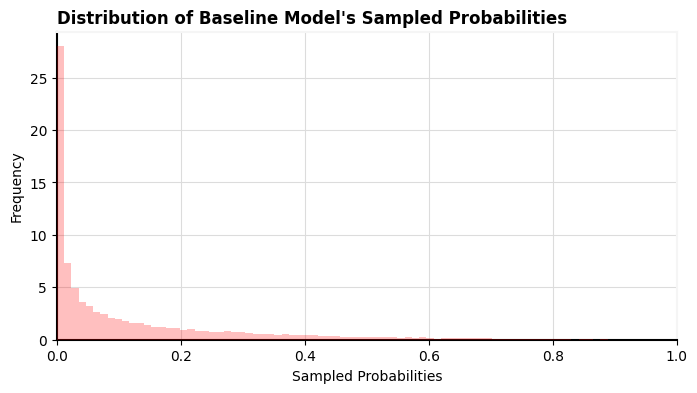

In [26]:
%%time
fig, ax = plt.subplots(figsize=(8, 4))
_ = ax.hist(
    df_test_preds['pred_proba'],
    density=True,
    bins="auto",
    color="red",
    histtype="stepfilled",
    alpha=0.25,
    label='baseline',
    zorder=10,
)
ax.set_xlim([0, 1])
ax.set_title(f"Distribution of Baseline Model's Sampled Probabilities", loc="left", fontweight="bold")
ax.set_xlabel("Sampled Probabilities")
ax.set_ylabel("Frequency")
customize_axis(ax)

**Notes**
1. There could be other distributions that can be used as a baseline model for the current use-case, but they were not explored in this version of the analysis.

**Observations**
1. As expected, the distribution is strongly right skewed with most probabilities being less than 10%. Also the range of sampled values produced by the `beta` distribution covers a range of 0.0 to 1.0. Both of these observations meet the requirements of a suitable baseline model that were discussed earlier.

#### **Assessing Evaluation Metrics by Sub-Category for All Categorical Features**

Next, for all categorical features in the transformed data of the test split, the sub-categories occurring with a frequency of at least 10% or higher. A list is also created that stores these popular sub-categories for each category so that the test data split can be filtered before calculating metrics.

This is done below

In [27]:
%%time
most_frequenct_sub_categories = []
for c in categorical_features:
    # get most popular sub-categories
    df_top_sub_cats_test = (
        (100 * df_test_preds[c].value_counts(normalize=True).rename("fraction"))
        .to_frame()
        .reset_index()
        .rename(columns={"index": c})
        .astype({c: pd.BooleanDtype() if c in ["bounces"] else pd.StringDtype()})
        .query("fraction >= 10")
    )
    display(df_top_sub_cats_test)

    # create list of popular sub-categories for each category
    most_frequenct_sub_categories.append({"feature": c, "top_sub_cats": df_top_sub_cats_test[c].tolist()})

,deviceCategory,fraction
0,desktop,67.304151
1,mobile,28.578174


,bounces,fraction
0,False,66.973603
1,True,33.026397


,channelGrouping,fraction
0,Organic Search,40.581763
1,Direct,29.012608
2,Referral,14.454361


,medium,fraction
0,organic,40.581763
1,(none),29.012608
2,referral,21.962506


,source,fraction
0,google,46.668556
1,(direct),29.012608
2,mall.googleplex.com,10.095859


CPU times: user 38.4 ms, sys: 1.27 ms, total: 39.6 ms
Wall time: 38.5 ms


The list of popular sub-categories is shown below for all categorical features

In [28]:
most_frequenct_sub_categories

[{'feature': 'deviceCategory', 'top_sub_cats': ['desktop', 'mobile']},
 {'feature': 'bounces', 'top_sub_cats': [False, True]},
 {'feature': 'channelGrouping',
  'top_sub_cats': ['Organic Search', 'Direct', 'Referral']},
 {'feature': 'medium', 'top_sub_cats': ['organic', '(none)', 'referral']},
 {'feature': 'source',
  'top_sub_cats': ['google', '(direct)', 'mall.googleplex.com']}]

Finally, we will iterate over all sub-categories and
- calculate metrics for each selected sub-category
- get metadata (number of observations) for each category and selected sub-category
  - here, observations is the same as visits

In [29]:
%%time
scores_records = []
for sub_cat_record in most_frequenct_sub_categories:
    top_sub_cats = sub_cat_record["top_sub_cats"]
    df_top_sub_cats = df_test_preds.query(f"{sub_cat_record['feature']}.isin(@top_sub_cats)")
    for sub_category in sub_cat_record['top_sub_cats']:
        sub_category_filter = f"'{sub_category}'" if sub_cat_record['feature'] != 'bounces' else sub_category
        df_sub_cat = df_test_preds.query(f"{sub_cat_record['feature']} == {sub_category_filter}")

        # get metrics
        scores = calculate_metrics(
            y_true=df_sub_cat['true'],
            y_pred=df_sub_cat['pred'],
            y_pred_proba=df_sub_cat['pred_proba'],
            df=df_sub_cat,
            params=best_hyperparameters,
            num_quantiles=num_quantiles,
            model_type='baseline',
            average="binary",
            zero_division="warn",
        )

        # add metadata
        scores.update(
            {
                "feature": sub_cat_record['feature'],
                "sub_category": sub_category,
                "observations_by_subcat": len(df_sub_cat),
                "observations_by_cat": len(df_top_sub_cats),
            }
        )
        print(
            f"Got scoring metrics for sub-category: {sub_category} "
            f"in feature: {sub_cat_record['feature']}"
        )
        scores_records.append(scores)
df_scores_eval_sub_cats = pd.DataFrame.from_records(scores_records)
# add ranks
df_scores_eval_sub_cats = df_scores_eval_sub_cats.assign(
    rank_lift_score=lambda df: df["lift_score"]
    .rank(method="dense", ascending=False)
    .astype(pd.Int8Dtype()),
    rank_uplift=lambda df: df["uplift"]
    .rank(method="dense", ascending=False)
    .astype(pd.Int8Dtype()),
    rank_lift_score_by_feature=lambda df: df.groupby("feature")["lift_score"]
    .transform("rank")
    .astype(pd.Int8Dtype()),
    rank_uplift_by_feature=lambda df: df.groupby("feature")["uplift"]
    .transform("rank")
    .astype(pd.Int8Dtype()),
)
with pd.option_context('display.max_columns', None):
    display(df_scores_eval_sub_cats.drop(columns=['accuracy', 'balanced_accuracy', 'model_type', 'params']))

Got scoring metrics for sub-category: desktop in feature: deviceCategory
Got scoring metrics for sub-category: mobile in feature: deviceCategory
Got scoring metrics for sub-category: False in feature: bounces
Got scoring metrics for sub-category: True in feature: bounces
Got scoring metrics for sub-category: Organic Search in feature: channelGrouping
Got scoring metrics for sub-category: Direct in feature: channelGrouping
Got scoring metrics for sub-category: Referral in feature: channelGrouping
Got scoring metrics for sub-category: organic in feature: medium
Got scoring metrics for sub-category: (none) in feature: medium
Got scoring metrics for sub-category: referral in feature: medium
Got scoring metrics for sub-category: google in feature: source
Got scoring metrics for sub-category: (direct) in feature: source
Got scoring metrics for sub-category: mall.googleplex.com in feature: source


,precision,recall,f1,f05,f2,brier,pr_auc,lift_score,uplift,true_class_imbalance,pred_class_imbalance,pct_chg_class_imbalance,feature,sub_category,observations_by_subcat,observations_by_cat,rank_lift_score,rank_uplift,rank_lift_score_by_feature,rank_uplift_by_feature
0,0.048889,0.063218,0.055138,0.051210,0.059718,0.079352,0.037993,1.334891,4.998728,26.304598,20.115556,-23.528366,deviceCategory,desktop,14253,20305,4,8,2,2
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.052379,0.001548,0.000000,0.000000,503.333333,18.842623,-96.256433,deviceCategory,mobile,6052,20305,10,10,1,1
2,0.042489,0.058700,0.049296,0.044973,0.054538,0.076148,0.034600,1.263346,5.112792,28.733753,20.522003,-28.578758,bounces,False,14183,21177,6,4,1,2
3,0.013587,0.084746,0.023419,0.016329,0.041391,0.059623,0.008922,1.610630,4.868216,117.542373,18.005435,-84.681750,bounces,True,6994,21177,1,9,2,1
4,0.007246,0.046875,0.012552,0.008721,0.022388,0.054922,0.007060,0.973053,5.519580,133.281250,19.758454,-85.175369,channelGrouping,Organic Search,8594,17799,7,3,1,3
5,0.052980,0.068376,0.059701,0.055479,0.064620,0.082031,0.041153,1.391068,5.007015,25.256410,19.344371,-23.408075,channelGrouping,Direct,6144,17799,2,6,3,1
6,0.094891,0.060185,0.073654,0.085079,0.064935,0.106828,0.071384,1.344722,5.096323,13.171296,21.343066,62.042256,channelGrouping,Referral,3061,17799,3,5,2,2
7,0.007246,0.046875,0.012552,0.008721,0.022388,0.054922,0.007060,0.973053,5.519580,133.281250,19.758454,-85.175369,medium,organic,8594,19389,7,3,1,3
8,0.052980,0.068376,0.059701,0.055479,0.064620,0.082031,0.041153,1.391068,5.007015,25.256410,19.344371,-23.408075,medium,(none),6144,19389,2,6,3,2
9,0.059322,0.064220,0.061674,0.060241,0.063177,0.091593,0.046477,1.265627,5.003399,20.334862,18.707627,-8.002195,medium,referral,4651,19389,5,7,2,1


CPU times: user 665 ms, sys: 0 ns, total: 665 ms
Wall time: 663 ms


**Observations**
1. The true average class imbalance ratio is in the range of 20 to 25 (or, 20:1 to 25:1). There are six sub-categories in the `true_class_imbalance` column, out of a total of 13 that were selected, that have a true class-imbalance ratio of more than 100 and that is outside this range. By comparison, the predicted class imbalance stays in the range of approximately 19 to 22. As we saw earlier, this baseline model has not learnt from inputs (features) so it is largely insensitive to changes in features and is the primary reason for this discrepancy in ranges.
2. Ranks by the `uplift` and `lift_score` metrics
   - within each feature
     - agree with eachother for the `bounces` feature but disagree for others
       - compare the `rank_lift_score_by_feature` and `rank_uplift_by_feature` columns
   - across all sub-categories
     - agree with eacother for three out of the 13 selected sub-categories
       - compare the `rank_lift_score` and `rank_uplift` columns
3. During hyperparameter tuning, the `pr_auc` and `precision` metrics did not change much as hyperparameters of the baseline model were changed. Here, the same two metrics show more sensitivity to the choice of sub-category. By reading through the rows of the `precision`, `pr_auc`, `true_class_imbalance`, `predicted_class_imbalance` and `feature` columns, we can say that based on these two metrics, the model's performance is qualitatively worse than the average across all selected sub-categories for the following
   - `deviceCategory == 'mobile'`
   - `bounces == 'True'`
   - `channelGrouping == 'Organic Search'`
   - `medium == 'organic'`
   - `source == 'google'`

   These are also five of the six sub-categories mentioned in 1. above that show a significant change in true class imbalance relative to the average true class imbalance. This further re-inforces the need for a model that can learn from features to better handle differences in the class imbalance between training and unseen data.

## Export to Disk

The scores from the baseline model evaluation section above will now be exported to disk so that ML model performance (in the next notebook) can be compared to the baseline performance found here.

Define datatypes for `DataFrame`s with the overall model evaluation scores

In [30]:
dtypes_dict_scores = {
    "accuracy": pd.Float32Dtype(),
    "balanced_accuracy": pd.Float32Dtype(),
    "precision": pd.Float32Dtype(),
    "recall": pd.Float32Dtype(),
    "f1": pd.Float32Dtype(),
    "f05": pd.Float32Dtype(),
    "f2": pd.Float32Dtype(),
    "brier": pd.Float32Dtype(),
    "pr_auc": pd.Float32Dtype(),
    "lift_score": pd.Float32Dtype(),
    "uplift": pd.Float32Dtype(),
    "true_class_imbalance": pd.Float32Dtype(),
    "pred_class_imbalance": pd.Float32Dtype(),
    "params": pd.StringDtype(),
    "model_type": pd.StringDtype(),
    "pct_chg_class_imbalance": pd.Float32Dtype(),
    "pct_chg_class_imbalance_abs": pd.Float32Dtype(),
}

Define datatypes for `DataFrame`s with the model evaluation scores by sub-category

In [31]:
dtypes_dict_scores_by_sub_category = {
    "accuracy": pd.Float32Dtype(),
    "balanced_accuracy": pd.Float32Dtype(),
    "precision": pd.Float32Dtype(),
    "recall": pd.Float32Dtype(),
    "f1": pd.Float32Dtype(),
    "f05": pd.Float32Dtype(),
    "f2": pd.Float32Dtype(),
    "brier": pd.Float32Dtype(),
    "pr_auc": pd.Float32Dtype(),
    "lift_score": pd.Float32Dtype(),
    "uplift": pd.Float32Dtype(),
    "true_class_imbalance": pd.Float32Dtype(),
    "pred_class_imbalance": pd.Float32Dtype(),
    "params": pd.StringDtype(),
    "model_type": pd.StringDtype(),
    "pct_chg_class_imbalance": pd.Float32Dtype(),
    "feature": pd.StringDtype(),
    "sub_category": pd.StringDtype(),
    "observations_by_subcat": pd.Int16Dtype(),
    "observations_by_cat": pd.StringDtype(),
    "rank_lift_score": pd.Int8Dtype(),
    "rank_uplift": pd.Int8Dtype(),
    "rank_lift_score_by_feature": pd.Int8Dtype(),
    "rank_uplift_by_feature": pd.Int8Dtype(),
}

Export overall evaluation scores

In [32]:
%%time
df_scores_eval.astype(dtypes_dict_scores).to_parquet(
    os.path.join(models_data_dir, 'baseline_scores_overall.parquet.gzip'),
    index=False, engine='pyarrow', compression='gzip'
)

Export evaluation scores by sub-category for the popular sub-categories in the categorical features

In [33]:
%%time
df_scores_eval_sub_cats.astype(dtypes_dict_scores_by_sub_category).to_parquet(
    os.path.join(models_data_dir, 'baseline_scores_by_sub_category.parquet.gzip'),
    index=False, engine='pyarrow', compression='gzip'
)

## Summary of Tasks Performed

This notebook trained a baseline model to predict visitor propensity to make a purchase during their next visit during January 2017.

The steps performed were
1. choose an appropriate baseline model to model prediction probabilities (predicted visitor propensities)
   - the `beta` distribution was chosen since [it randomly samples values between 0 and 1](https://www.sciencedirect.com/topics/mathematics/beta-distribution), which is required for the current use-case
2. model validation
   - optimize hyperparameters of the baseline model
   - uses validation data split
   - determines best hyperparameters
3. model evaluation
   - uses model with best hyperparameters to make predictions on data that has not been seen during ML model development
   - uses test data split
   - post-processing
     - assesses model's performance across the most popular sub-categories in all categorical features in the transformed data from the test data split

## Key Findings

1. The baseline model cannot generalize since it does not use features. It cannot handle changes in class imbalance seen between model validation and model evaluation.
   - input features will likely be key to improving on this performance using a ML model
2. Several evaluation metrics are more sentitive to changes in sub-category than to changes in baseline model hyperparameters
   - model performance should be compared to ML model performance for each of the popular sub-categories
   - this further re-inforces the finding from 1. above
3. The `uplift` and `lift_score` evaluation metrics are defined differently and do not always agree in ranking predictions by model hyperparameters and sub-categories of categorical features
   - `lift_score` was defined based on the confusion matrix
   - `uplift` was manually defined based on the current use-case
   - while both definitions provide a metric, the uplift-based approach is more powerful since it also allows the ventiles to be visualized

## Summary of Assumptions

1. It is assumed that the class imbalance can be adequately represented by the `beta` distribution. The parameters of this distribution are modified during model validation in order to capture the class-imbalance seen in the validation data split.
2. The top three sub-categories are considered for evaluating baseline model performance since these occurred in at least 10% of all observations (visits) per category.

## Limitations

1. A single choice of skewed distribution (`beta`) was used to represent the baseline model. This was chosen since it can sample values in the range of 0 to 1, which is the range of prediction probabilities that we want for a binary classification model.
2. For the `uplift` evaluation metric, ventiles (20 bins) were used. However, other binning approaches (deciles, which would give 10 bins) were not explored.
3. The first definition of `uplift` does not make a comparison of the predicted and true class labels. Instead, it only defines ventiles based on the predicted probability. This is acceptable since uplift is meant to compare a model's predictive power to a random model. However, this also means it is possible to have a non-zero uplift with an inaccurate model. For this reason, the other metric (area under the precision-recall curve) must also be used to evaluate model performance, in addition to `uplift`.
4. The baseline model does not learn from features so its hyperparameters were only chosen based on its ability to match the class imbalance seen in the validation data split. This does not generalize to unseen data with a different class imbalance, but this is adequate for a baseline model.

## Next Step

The next notebook of this project will repeat the analysis in this notebook, but with a machine learning model used in place of the baseline visitor propensity (binary classifier) model used here. A ML model that is able to deliver value to the business user for this project should outperform the evaluation scores reported here for the baseline model.

Since the end-to-end ML development workflow is very similar to the workflow shown here, comments will only be included in that notebook for new steps, such as feature engineering, feature transformation, etc., that were not necessary for a baseline model.

---